In [1]:
import pandas as pd
import numpy as np
from glob import glob
from matplotlib import pyplot as plt

In [2]:
masks = glob(r'C:\Users\Administrator\Desktop\Dataset\*\*_mask*')
images = []
for i in masks:
    i = i.replace('_mask' , '')
    images.append(i)

In [3]:
df = pd.DataFrame({'images':images, 'masks':masks})

In [4]:
pd.set_option('display.max_colwidth', None)
df.head()

,images,masks
0,C:\Users\Administrator\Desktop\Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_10.tif,C:\Users\Administrator\Desktop\Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_10_mask.tif
1,C:\Users\Administrator\Desktop\Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_11.tif,C:\Users\Administrator\Desktop\Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_11_mask.tif
2,C:\Users\Administrator\Desktop\Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_12.tif,C:\Users\Administrator\Desktop\Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_12_mask.tif
3,C:\Users\Administrator\Desktop\Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_13.tif,C:\Users\Administrator\Desktop\Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_13_mask.tif
4,C:\Users\Administrator\Desktop\Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_14.tif,C:\Users\Administrator\Desktop\Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_14_mask.tif


In [5]:
print("Shape of the dataframe is ",df.shape)

Shape of the dataframe is  (3929, 2)


In [6]:
"""def tumor_detect(path):
    mask = plt.imread(path)
    if np.max(mask) != 0.0:
        return 1
    else:
        return 0
# use the above functions to remove images with no tumor
df['mask'] = df['masks'].apply(lambda x: tumor_detect(x))
df = df[df['mask'] == 1]
df"""


"def tumor_detect(path):\n    mask = plt.imread(path)\n    if np.max(mask) != 0.0:\n        return 1\n    else:\n        return 0\n# use the above functions to remove images with no tumor\ndf['mask'] = df['masks'].apply(lambda x: tumor_detect(x))\ndf = df[df['mask'] == 1]\ndf"

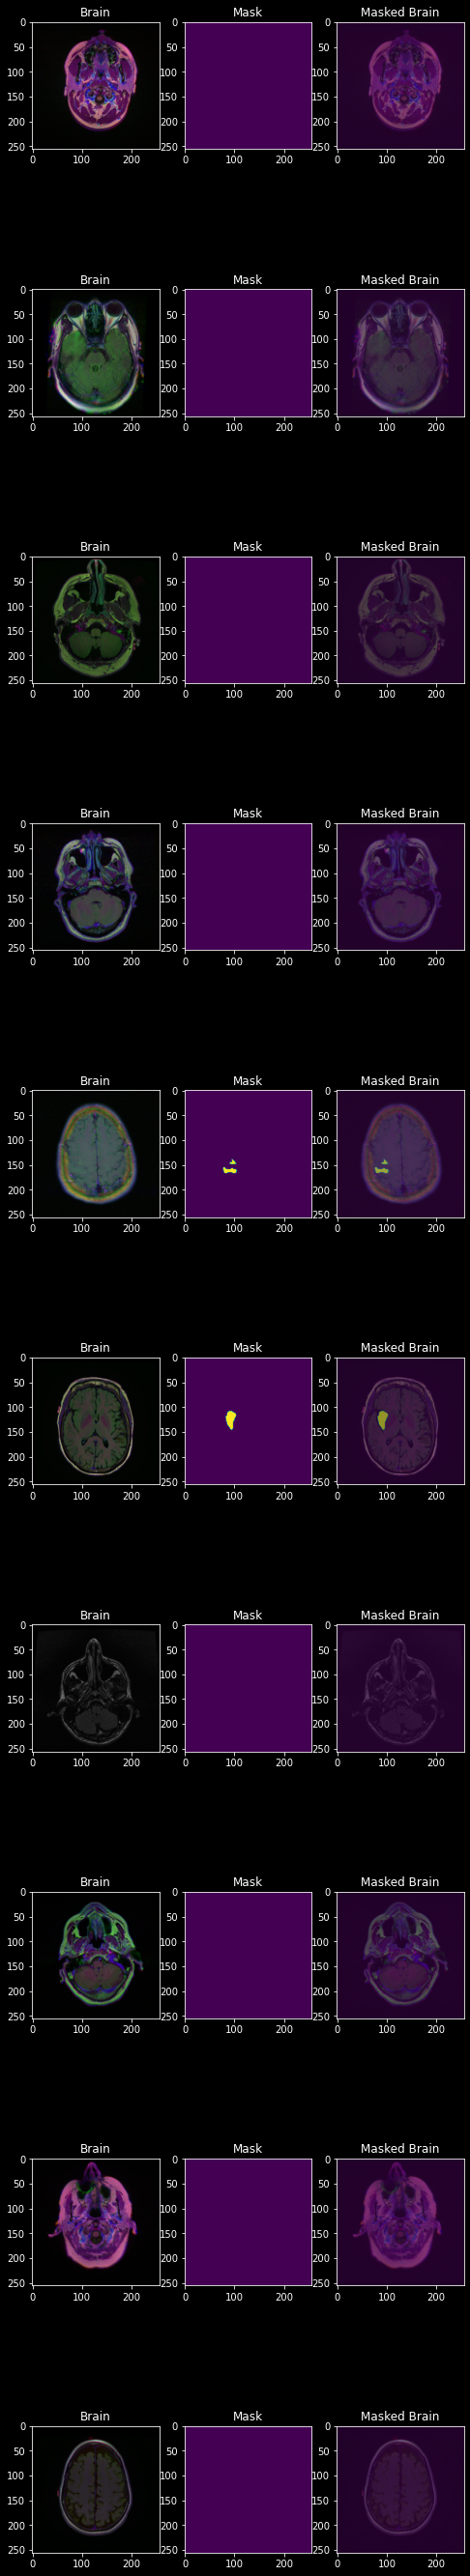

In [7]:
#Visualize the data
import cv2
import random
import matplotlib.pyplot as plt
#Let's look at the images of the mri scans of the brain along with the masks, an empty mask means no tumor
num = 10
fig,ax = plt.subplots(num,3,figsize=(8,50))
for i in range(num):
    #add title for every image
    ax[i,0].set_title('Brain')
    ax[i,1].set_title('Mask')
    ax[i,2].set_title('Masked Brain')
    #randomly select an image
    a = random.randint(0,df.shape[0])
    ax[i,0].imshow(plt.imread(df['images'].iloc[a]))
    ax[i,1].imshow(plt.imread(df['masks'].iloc[a]))
    ax[i,2].imshow(plt.imread(df['images'].iloc[a]))
    ax[i,2].imshow(plt.imread(df['masks'].iloc[a]),alpha=0.5)

In [8]:
from sklearn.model_selection import train_test_split
# Split the data into training_data, validation_data and testing_data
training_df, testing_df = train_test_split(df, test_size=0.1, random_state=265, shuffle=True)
training_df, validation_df = train_test_split(training_df, test_size=0.1, random_state=360, shuffle=True)
print('Number of training samples: ', len(training_df))
print('Number of validation samples: ', len(validation_df))
print('Number of testing samples: ', len(testing_df))

Number of training samples:  3182
Number of validation samples:  354
Number of testing samples:  393


In [9]:
import albumentations as A

# create augmentations to increase the size of the dataset

def create_training_augmentations():
    return A.Compose([
        A.Resize(height=256, width=256, always_apply=True),
        A.HorizontalFlip(p=0.4),
        A.VerticalFlip(p=0.4),
        A.Rotate(limit=105, p=0.3),
        A.Rotate(limit=35, p=0.2)
    ])

def create_validation_augmentations():
    return A.Compose([
        A.Resize(height=256, width=256, always_apply=True),
    ])

def create_testing_augmentations():
    return A.Compose([
        A.Resize(height=256, width=256, always_apply=True),
    ])


In [10]:
from torch.utils.data import DataLoader, Dataset
import cv2
import torch

class Brain_Mri_Scans_Dataset(Dataset):

    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):

        image_path = self.df.iloc[idx]['images']
        mask_path = self.df.iloc[idx]['masks']

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE)
        # add one channel at the end as it is grayscale
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations is not None:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
            
        # pytorch expects the channels to be first
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
        
        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [11]:
trainset = Brain_Mri_Scans_Dataset(training_df, augmentations=create_training_augmentations())
valset = Brain_Mri_Scans_Dataset(validation_df, augmentations=create_validation_augmentations())

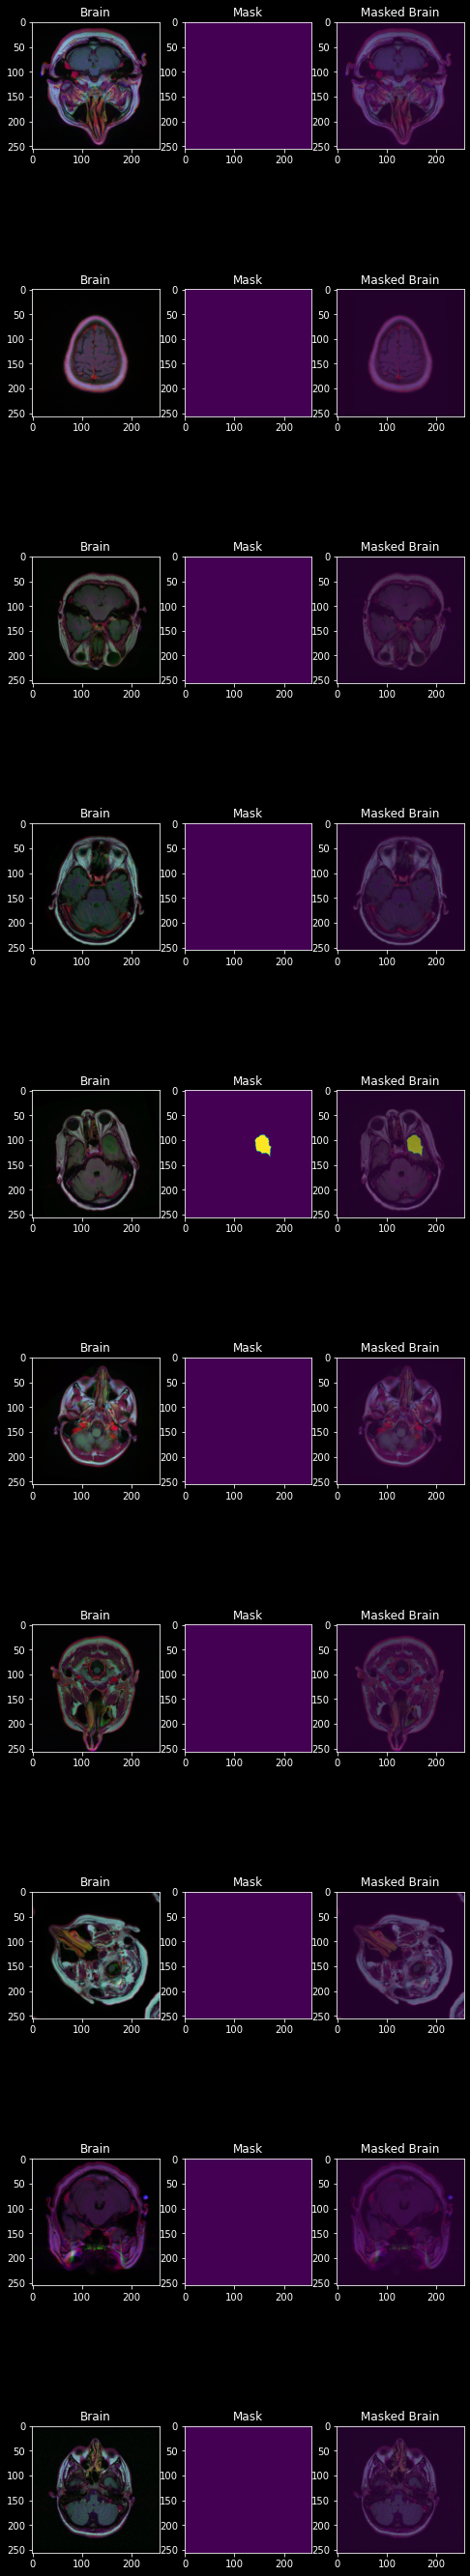

In [12]:
# Let us see some of the images from trainset
num = 10
fig,ax = plt.subplots(num,3,figsize=(8,50))
for i in range(num):
    #add title for every image
    ax[i,0].set_title('Brain')
    ax[i,1].set_title('Mask')
    ax[i,2].set_title('Masked Brain')
    #randomly select an image
    a = random.randint(0,trainset.__len__())
    temp = trainset[a]
    brain = (temp[0]).permute(1,2,0)
    mask = (temp[1]).permute(1,2,0)
    ax[i,0].imshow(brain)
    ax[i,1].imshow(mask)
    ax[i,2].imshow(brain)
    ax[i,2].imshow(mask,alpha=0.5)


In [13]:
# Check how many masks are empty which indirecly means no tumor
empty_masks = 0
for i in range(len(trainset)):
    if (trainset[i][1]).sum() == 0:
        empty_masks += 1
print("Number of empty masks in the training set is ",empty_masks)
print("Total masks in the training set is ",len(trainset))

Number of empty masks in the training set is  2055
Total masks in the training set is  3182


In [14]:
# Let's prepare the dataloaders now
batch_size = 18
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size)

print(f"Number of batches in the training set is {len(train_loader)}")
print(f"Number of batches in the validation set is {len(val_loader)}")

Number of batches in the training set is 177
Number of batches in the validation set is 20


In [15]:
for image, mask in train_loader:
    print("Shape of one batch of images is: ",image.shape)
    print("Shape of one batch of masks is: ",mask.shape)
    break

Shape of one batch of images is:  torch.Size([18, 3, 256, 256])
Shape of one batch of masks is:  torch.Size([18, 1, 256, 256])


In [16]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

class Brain_Mri_Model(nn.Module):

    def __init__(self):
        super(Brain_Mri_Model , self).__init__()

        self.architecture = smp.Unet(
            encoder_name='resnet34',
            encoder_weights='imagenet',
            classes=1,
            in_channels=3,
            activation=None
        )

    def forward(self, images, masks = None):
        outputs = self.architecture(images)
        if masks is not None:
            loss = DiceLoss(mode = 'binary')(outputs, masks)
            return outputs, loss
        else:
            return outputs

In [17]:
model = Brain_Mri_Model()
model.to('cuda')

Brain_Mri_Model(
  (architecture): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         

In [18]:
from tqdm import tqdm
# create the training function
def train_model(data_loader, model , optimizer):
    model.train()
    total_loss = 0.0
    for images, masks in tqdm(data_loader):
        images = images.to('cuda')
        masks = masks.to('cuda')

        optimizer.zero_grad()
        outputs , loss = model(images, masks)
        loss.backward()
        optimizer.step()
        scheduler.step(val_loss)

        total_loss += loss.item()
        
    return total_loss / len(data_loader) 

In [19]:
# create the validation/testing function, we will use the same function for both validation and testing 
def test_model(data_loader, model):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to('cuda')
            masks = masks.to('cuda')
            outputs, loss = model(images, masks)
            total_loss += loss.item()
    return total_loss / len(data_loader) 
    

100%|██████████| 20/20 [00:02<00:00,  6.95it/s]


Epoch 1/30 train loss: 0.5740 val loss: 0.4241
Saved the best model at epoch  1


100%|██████████| 20/20 [00:02<00:00,  6.85it/s]


Epoch 2/30 train loss: 0.3666 val loss: 0.3906
Saved the best model at epoch  2


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


Epoch 3/30 train loss: 0.3324 val loss: 0.2930
Saved the best model at epoch  3


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


Epoch 4/30 train loss: 0.3015 val loss: 0.2431
Saved the best model at epoch  4


100%|██████████| 20/20 [00:04<00:00,  4.73it/s]


Epoch 5/30 train loss: 0.2902 val loss: 0.2826


 70%|███████   | 124/177 [00:59<00:25,  2.11it/s]

Epoch 01010: reducing learning rate of group 0 to 6.5000e-04.


100%|██████████| 20/20 [00:03<00:00,  6.59it/s]


Epoch 6/30 train loss: 0.2686 val loss: 0.2673


100%|██████████| 20/20 [00:03<00:00,  6.29it/s]


Epoch 7/30 train loss: 0.2289 val loss: 0.1972
Saved the best model at epoch  7


100%|██████████| 20/20 [00:03<00:00,  6.33it/s]


Epoch 8/30 train loss: 0.2262 val loss: 0.2324


 70%|███████   | 124/177 [00:56<00:23,  2.25it/s]

Epoch 01541: reducing learning rate of group 0 to 4.2250e-04.


100%|██████████| 20/20 [00:02<00:00,  6.68it/s]


Epoch 9/30 train loss: 0.1996 val loss: 0.2110


100%|██████████| 20/20 [00:03<00:00,  6.08it/s]


Epoch 10/30 train loss: 0.1735 val loss: 0.2050


 40%|████      | 71/177 [00:31<00:47,  2.25it/s]

Epoch 01842: reducing learning rate of group 0 to 2.7463e-04.


100%|██████████| 20/20 [00:03<00:00,  6.55it/s]


Epoch 11/30 train loss: 0.1962 val loss: 0.1501
Saved the best model at epoch  11


100%|██████████| 20/20 [00:04<00:00,  4.36it/s]


Epoch 12/30 train loss: 0.1678 val loss: 0.1437
Saved the best model at epoch  12


100%|██████████| 20/20 [00:04<00:00,  4.71it/s]


Epoch 13/30 train loss: 0.1541 val loss: 0.1448


 70%|███████   | 124/177 [00:59<00:25,  2.08it/s]

Epoch 02426: reducing learning rate of group 0 to 1.7851e-04.


100%|██████████| 20/20 [00:02<00:00,  6.73it/s]


Epoch 14/30 train loss: 0.1489 val loss: 0.1415
Saved the best model at epoch  14


100%|██████████| 20/20 [00:03<00:00,  6.53it/s]


Epoch 15/30 train loss: 0.1409 val loss: 0.1276
Saved the best model at epoch  15


100%|██████████| 20/20 [00:03<00:00,  6.61it/s]


Epoch 16/30 train loss: 0.1460 val loss: 0.1349


 70%|███████   | 124/177 [00:56<00:23,  2.28it/s]

Epoch 02957: reducing learning rate of group 0 to 1.1603e-04.


100%|██████████| 20/20 [00:03<00:00,  5.43it/s]


Epoch 17/30 train loss: 0.1444 val loss: 0.1288


100%|██████████| 20/20 [00:02<00:00,  6.92it/s]


Epoch 18/30 train loss: 0.1358 val loss: 0.1220
Saved the best model at epoch  18


100%|██████████| 20/20 [00:02<00:00,  6.94it/s]


Epoch 19/30 train loss: 0.1312 val loss: 0.1202
Saved the best model at epoch  19


100%|██████████| 20/20 [00:02<00:00,  6.88it/s]


Epoch 20/30 train loss: 0.1351 val loss: 0.1216


 70%|███████   | 124/177 [00:54<00:23,  2.29it/s]

Epoch 03665: reducing learning rate of group 0 to 7.5419e-05.


100%|██████████| 20/20 [00:02<00:00,  6.79it/s]


Epoch 21/30 train loss: 0.1318 val loss: 0.1207


100%|██████████| 20/20 [00:02<00:00,  6.79it/s]


Epoch 22/30 train loss: 0.1302 val loss: 0.1237


 40%|████      | 71/177 [00:31<00:45,  2.31it/s]

Epoch 03966: reducing learning rate of group 0 to 4.9022e-05.


100%|██████████| 20/20 [00:03<00:00,  6.31it/s]


Epoch 23/30 train loss: 0.1254 val loss: 0.1230


100%|██████████| 20/20 [00:02<00:00,  6.90it/s]


Epoch 24/30 train loss: 0.1306 val loss: 0.1209


 10%|█         | 18/177 [00:07<01:09,  2.28it/s]

Epoch 04267: reducing learning rate of group 0 to 3.1864e-05.


100%|██████████| 20/20 [00:02<00:00,  6.91it/s]


Epoch 25/30 train loss: 0.1229 val loss: 0.1201
Saved the best model at epoch  25


100%|██████████| 20/20 [00:02<00:00,  6.75it/s]


Epoch 26/30 train loss: 0.1202 val loss: 0.1189
Saved the best model at epoch  26


100%|██████████| 20/20 [00:02<00:00,  6.93it/s]


Epoch 27/30 train loss: 0.1186 val loss: 0.1183
Saved the best model at epoch  27


100%|██████████| 20/20 [00:02<00:00,  7.54it/s]


Epoch 28/30 train loss: 0.1143 val loss: 0.1177
Saved the best model at epoch  28


100%|██████████| 20/20 [00:02<00:00,  6.83it/s]


Epoch 29/30 train loss: 0.1180 val loss: 0.1137
Saved the best model at epoch  29


100%|██████████| 20/20 [00:02<00:00,  7.64it/s]


Epoch 30/30 train loss: 0.1195 val loss: 0.1157


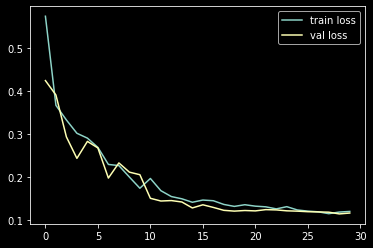

In [20]:
# create the optmimzer and decay the learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.65, patience= 300, verbose=True)

# we will use smallest loss later to select and save the best model during training
smallest_loss = np.inf
epochs = 30
val_loss = 9999999

train_loss_values = []
val_loss_values = []

for i in range(epochs):
    train_loss = train_model(train_loader, model, optimizer)
    val_loss = test_model(val_loader, model)
    print(f"Epoch {i+1}/{epochs} train loss: {train_loss:.4f} val loss: {val_loss:.4f}")
    
    if val_loss < smallest_loss:
        smallest_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved the best model at epoch ",i+1)
    train_loss_values.append(train_loss)
    val_loss_values.append(val_loss)
    
# display the loss graph at the end of training
plt.plot(train_loss_values, label = 'train loss')
plt.plot(val_loss_values, label = 'val loss')
plt.legend()
plt.show()
        

In [21]:
def tumor_detect(path):
    mask = plt.imread(path)
    if np.max(mask) != 0.0:
        return 1
    else:
        return 0
# use the above functions to remove images from the testset with no tumor, we will use another model for checking if the brain mri scan has tumor
testing_df['mask'] = testing_df['masks'].apply(lambda x: tumor_detect(x))
testing_df = testing_df[testing_df['mask'] == 1]
testset = Brain_Mri_Scans_Dataset(testing_df, augmentations=create_testing_augmentations())

C:\Users\Administrator\AppData\Local\Temp\ipykernel_79576\631771592.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df['mask'] = testing_df['masks'].apply(lambda x: tumor_detect(x))


Average Dice Coefficient is 0.8550580730725547
Average IoU Score is 0.7647851549507871


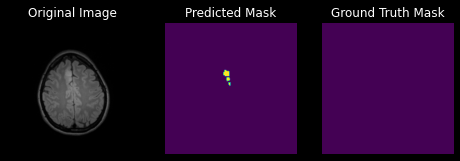

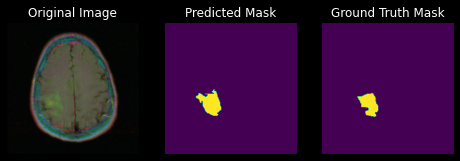

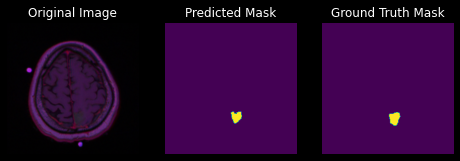

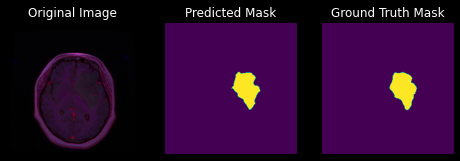

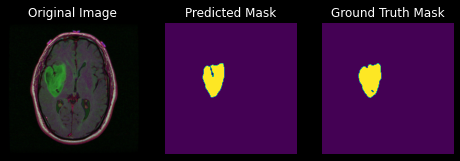

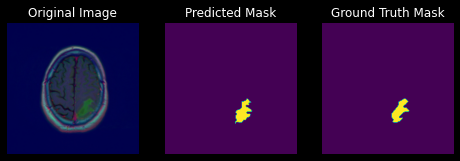

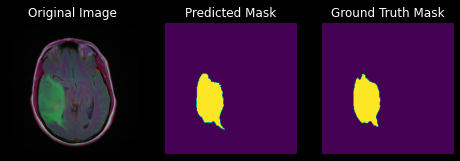

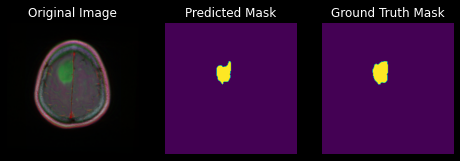

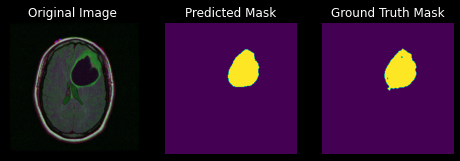

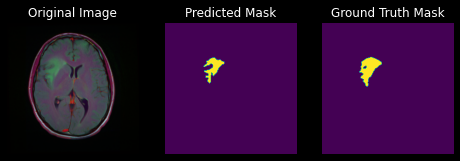

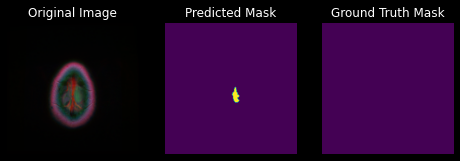

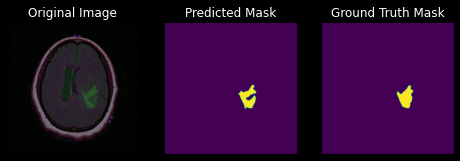

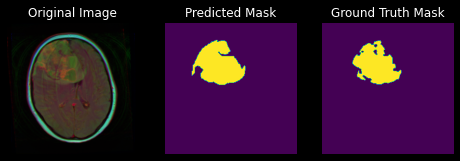

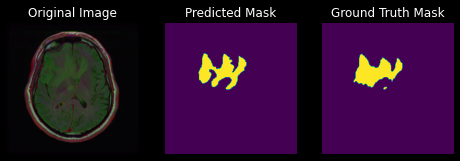

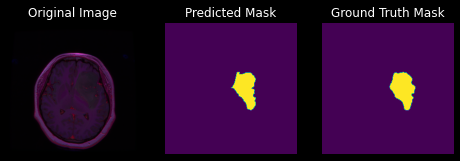

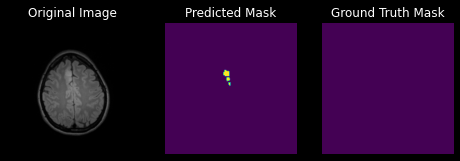

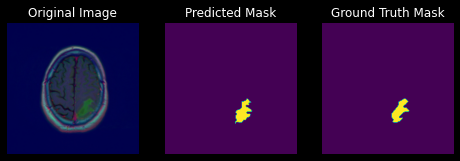

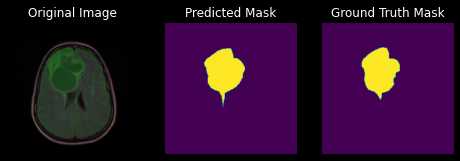

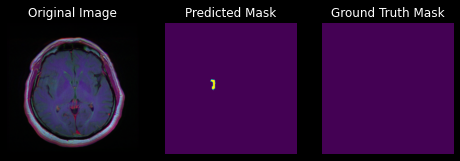

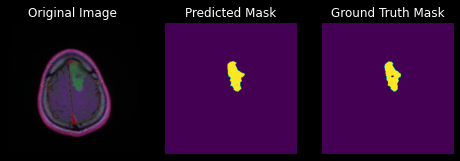

In [26]:
#let's load the best saved model now
model = Brain_Mri_Model()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
def Dice_Coefficient(pred, target):
    pred = pred.cpu().detach().numpy()
    target = target.cpu().numpy()
    pred = pred > 0.5
    target = target > 0.5
    intersection = np.logical_and(pred, target)
    return 2 * intersection.sum() / (pred.sum() + target.sum())

def IoU_score(pred, target):
    pred = pred.cpu().detach().numpy()
    target = target.cpu().numpy()
    pred = pred > 0.5
    target = target > 0.5
    intersection = np.logical_and(pred, target)
    union = np.logical_or(pred, target)
    score = np.sum(intersection) / np.sum(union)
    return score
# Let us calculate the Dice Coefficient and the IoU score for the test set
dice_coefficient = 0
iou_score = 0
dice_count = 0
iou_count = 0
for id in range(len(testset)):
    image , mask = testset[id]
    logits_mask = model(image.unsqueeze(0))
    if Dice_Coefficient(logits_mask, mask) > 0:
        dice_coefficient += Dice_Coefficient(logits_mask, mask)
        dice_count += 1
    if IoU_score(logits_mask, mask) > 0:
        iou_score += IoU_score(logits_mask, mask)
        iou_count += 1

print(f"Average Dice Coefficient is {dice_coefficient/dice_count}")
print(f"Average IoU Score is {iou_score/iou_count}")



#visualise some testset images with the predictions of our model
for i in range(20):
    id = np.random.randint(0,len(testset))
    image , mask = testset[id]
    logits_mask = model(image.unsqueeze(0))
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5)*1.0
    fig,ax = plt.subplots(1,3,figsize=(8,8))
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[0].set_title('Original Image')
    ax[1].set_title('Predicted Mask')
    ax[2].set_title('Ground Truth Mask')
    ax[0].imshow(image.permute(1,2,0))
    ax[1].imshow(mask.permute(1,2,0))
    ax[2].imshow(pred_mask.squeeze().cpu())
